# **1. 데이터셋 준비**

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms

import os
import json
import zipfile
import random
import numpy as np
from PIL import Image

## **1-1. 데이터셋 불러오기**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**이미지 파일 압축 해제**
- 본인 경로를 제대로 설정했는지 확인
- 세션 디스크에 `data > train` 폴더를 만들어두고 압축 해제 진행하셔야 합니다..!
  - 세션 디스크 내 임시 경로로, 드라이브 x

```
!unzip (데이터 경로) -d (압축 해제할 경로)
```

In [ ]:
### 이미지 파일 압축 해제

!unzip /content/drive/MyDrive/6th-project/final/data/train.zip -d /content/data/train
!unzip /content/drive/MyDrive/6th-project/final/data/val.zip -d /content/data/val

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/data/train/image_64.jpg  
  inflating: /content/data/train/image_640.jpg  
  inflating: /content/data/train/image_6400.jpg  
  inflating: /content/data/train/image_6401.jpg  
  inflating: /content/data/train/image_6402.jpg  
  inflating: /content/data/train/image_6403.jpg  
  inflating: /content/data/train/image_6404.jpg  
  inflating: /content/data/train/image_6405.jpg  
  inflating: /content/data/train/image_6406.jpg  
  inflating: /content/data/train/image_6407.jpg  
  inflating: /content/data/train/image_6408.jpg  
  inflating: /content/data/train/image_6409.jpg  
  inflating: /content/data/train/image_641.jpg  
  inflating: /content/data/train/image_6410.jpg  
  inflating: /content/data/train/image_6411.jpg  
  inflating: /content/data/train/image_6412.jpg  
  inflating: /content/data/train/image_6413.jpg  
  inflating: /content/data/train/image_6414.jpg  
  inflating: /content/data/train/image_6415.jpg  
  inflating: /cont

In [ ]:
### annotations 파일 준비

coco_train_path = '/content/drive/MyDrive/6th-project/final/data/coco_train.json'
coco_val_path = '/content/drive/MyDrive/6th-project/final/data/coco_val.json'

## **1-2. Custom Dataset 준비**

In [ ]:
### Custom Dataset 클래스 정의

class FashionDataset(Dataset):
  def __init__(self, annotation_file, image_dir, transform = None):
    with open(annotation_file, 'r') as f:
      self.coco_data = json.load(f)
    self.image_dir = image_dir
    self.transform = transform

  def __len__(self):
    return len(self.coco_data['annotations'])

  def __getitem__(self, idx):
    ## 속성 정보
    annotation = self.coco_data['annotations'][idx]

    ## 이미지
    image_id = annotation['image_id']

    image_info = next((img for img in self.coco_data['images'] if img['id'] == image_id), None)
    image_path = os.path.join(self.image_dir, image_info['file_name'])

    image = Image.open(image_path).convert('RGB')
    if self.transform:
      image = self.transform(image)

    ## 캡션
    caption = annotation['caption']

    return image, caption

In [ ]:
## 데이터셋 준비

# 이미지 전처리
transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
])

In [ ]:
train_dataset = FashionDataset(annotation_file = coco_train_path,
                               image_dir = '/content/data/train',
                               transform = transform)

In [ ]:
val_dataset = FashionDataset(annotation_file = coco_val_path,
                               image_dir = '/content/data/val',
                               transform = transform)

In [ ]:
### DataLoader 설정

train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 16, shuffle = False)

# **2. Training(fine-tuning)**

In [ ]:
!pip install peft

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from transformers import AdamW, get_cosine_schedule_with_warmup

from tqdm import tqdm
import matplotlib.pyplot as plt

from peft import get_peft_model, LoraConfig

## **2-1. model 준비**

In [ ]:
### Pre-trained model 불러오기

# 전처리기
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large", do_rescale=False)

# 모델
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/527 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
### 장치 설정

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-23): 24 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (projection): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (layer_norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((1024,),

In [ ]:
### target layer 가져오기
# 특정한 pattern으로 탐색

def get_target_modules(model, patterns):
    target_modules = []
    for name, module in model.named_modules():
        for pattern in patterns:
            if pattern in name:
                target_modules.append(name)
    return target_modules

In [ ]:
## 예시
# 조합에 따라 바꿔야함(layer 찍어서 구조 확인해보기)

decoder_patterns = ["self.query", "self.key", "self.value", "intermediate.dense", "output.dense"]
encoder_patterns = ["self_attn.qkv", "mlp.fc"]

encoder_modules = get_target_modules(model, encoder_patterns)[-18:] # 마지막 6개 layer만 가져오려고..
                                                                    # 조건에 따라 바꿔야 함
decoder_modules = get_target_modules(model, decoder_patterns)

target_modules = encoder_modules+ decoder_modules

In [ ]:
## PEFT + LoRA 설정

## LoRA Configuration
lora_config = LoraConfig(
    r = 16, # LoRA의 rank
    lora_alpha = 32, # LoRA의 alpha
    lora_dropout = 0.05, # LoRA의 dropout 비율
    target_modules = target_modules,
    bias = "none"
)

# LoRA 적용 모델
peft_model = get_peft_model(model, lora_config)

In [ ]:
for modules in peft_model.targeted_module_names:
  print(modules)

vision_model.encoder.layers.18.self_attn.qkv
vision_model.encoder.layers.18.mlp.fc1
vision_model.encoder.layers.18.mlp.fc2
vision_model.encoder.layers.19.self_attn.qkv
vision_model.encoder.layers.19.mlp.fc1
vision_model.encoder.layers.19.mlp.fc2
vision_model.encoder.layers.20.self_attn.qkv
vision_model.encoder.layers.20.mlp.fc1
vision_model.encoder.layers.20.mlp.fc2
vision_model.encoder.layers.21.self_attn.qkv
vision_model.encoder.layers.21.mlp.fc1
vision_model.encoder.layers.21.mlp.fc2
vision_model.encoder.layers.22.self_attn.qkv
vision_model.encoder.layers.22.mlp.fc1
vision_model.encoder.layers.22.mlp.fc2
vision_model.encoder.layers.23.self_attn.qkv
vision_model.encoder.layers.23.mlp.fc1
vision_model.encoder.layers.23.mlp.fc2
text_decoder.bert.encoder.layer.0.attention.self.query
text_decoder.bert.encoder.layer.0.attention.self.key
text_decoder.bert.encoder.layer.0.attention.self.value
text_decoder.bert.encoder.layer.0.attention.output.dense
text_decoder.bert.encoder.layer.0.crossatt

## **2-2. 평가 지표 준비**

In [ ]:
!git clone https://github.com/salaniz/pycocoevalcap
!pip install git+https://github.com/salaniz/pycocoevalcap.git

Cloning into 'pycocoevalcap'...
remote: Enumerating objects: 821, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 821 (delta 5), reused 15 (delta 4), pack-reused 797 (from 1)
Receiving objects: 100% (821/821), 130.06 MiB | 13.87 MiB/s, done.
Resolving deltas: 100% (424/424), done.
  Cloning https://github.com/salaniz/pycocoevalcap.git to /tmp/pip-req-build-2j5yln20
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap.git /tmp/pip-req-build-2j5yln20
  Resolved https://github.com/salaniz/pycocoevalcap.git to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-py3-none-any.whl size=104312246 sha256=085d6939efb1220a27b046bf6d8cdd8526b4bb6874a007117a52637519f6a1de
  Stored in directory: /tmp/pip-ephem-wheel-cache-_ysb09k_/wheels/57/de/9f/7aa9ae75f4e4733cc4b66b5c3a65a05de62a28e8111649fe

In [ ]:
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice

In [ ]:
### 평가 지표 계산

def compute_metrics(preds, labels):
  scorers = [
      (Bleu(4), "BLEU-4"),
      (Meteor(), "METEOR"),
      (Rouge(), "ROUGE"),
      (Cider(), "CIDEr"),
      (Spice(), "SPICE")
  ]

  results = {}
  for scorer, method in scorers:
    score, _ = scorer.compute_score({i: [labels[i]] for i in range(len(labels))}, {i: [preds[i]] for i in range(len(preds))})
    results[method] = score if isinstance(score, float) else score[-1]

  return results

## **2-3. 학습 및 검증**

In [ ]:
### 옵티마이저 및 Learning Rate Schedule 정의

## 옵티마이저
optimizer = AdamW(filter(lambda p: p.requires_grad, peft_model.parameters()),
                  lr = 2e-5, weight_decay = 0.05)

## learning rate schedule
num_training_steps = len(train_loader) * 10  # 10 에포크
num_warmup_steps = int(0.1 * num_training_steps)  # Warmup 비율 10%
scheduler = get_cosine_schedule_with_warmup(optimizer,
                                            num_warmup_steps = num_warmup_steps,
                                            num_training_steps = num_training_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
## 학습 및 검증 손실, 평가 지표 기록

train_losses = []
val_losses = []
best_val_loss = float('inf')

bleu_scores = []
meteor_scores = []
rouge_scores = []
cider_scores = []
spice_scores = []

In [ ]:
### 학습을 위한 함수

def train(model, train_loader, val_loader, optimizer, scheduler, device, num_epochs):
  global best_val_loss

  for epoch in range(num_epochs):
    print(f"=== Epoch {epoch+1} ===")
    print("-" * 20)

    ## Training loop
    model.train()  # 모델 학습 모드로 설정
    epoch_train_loss = 0

    for batch_idx, (images, captions) in enumerate(tqdm(train_loader, desc = f"Training Epoch {epoch+1}/{num_epochs}")):
      images = images.to(device)

      # 전처리
      inputs = processor(images = images, text = captions, return_tensors = "pt", padding = True).to(device)

      # 모델에 입력
      outputs = model(**inputs, labels = inputs.input_ids)

      # 손실 계산 및 역전파
      loss = outputs.loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      scheduler.step()  # Learning rate 스케줄링

      epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}, Average Training Loss: {avg_train_loss:.4f}")


    ## Validation loop
    model.eval()  # 모델 평가 모드로 설정
    epoch_val_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
      for images, captions in tqdm(val_loader, desc = "Validation"):
        images = images.to(device)
        inputs = processor(images = images, text = captions, return_tensors = "pt", padding = True).to(device)

        outputs = model(**inputs, labels = inputs.input_ids)
        loss = outputs.loss
        epoch_val_loss += loss.item()

        # Generate captions
        generated_ids = model.generate(pixel_values = inputs.pixel_values, max_length = 30)
        generated_texts = processor.batch_decode(generated_ids, skip_special_tokens = True)

        # Collect predictions and labels for evaluation
        all_preds.extend(generated_texts)
        all_labels.extend(captions)

    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1}, Average Validation Loss: {avg_val_loss:.4f}")

    ## Calculate evaluation metrics
    metrics = compute_metrics(all_preds, all_labels)

    bleu_scores.append(metrics['BLEU-4'])
    meteor_scores.append(metrics['METEOR'])
    rouge_scores.append(metrics['ROUGE'])
    cider_scores.append(metrics['CIDEr'])
    spice_scores.append(metrics['SPICE'])

    print(f"BLEU: {metrics['BLEU-4']:.4f}, METEOR: {metrics['METEOR']:.4f}, ROUGE: {metrics['ROUGE']:.4f}, CIDEr: {metrics['CIDEr']:.4f}, SPICE: {metrics['SPICE']:.4f}")


    ## Best model 저장
    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      torch.save(model.state_dict(), "/content/drive/MyDrive/6th-project/final/model/model_trial_xxx.pth") # 모델명 trial에 맞게 바꿔주세요.
      print(f"Model saved at Epoch {epoch+1} with Validation Loss: {avg_val_loss:.4f}")

    ## Clear cache
    torch.cuda.empty_cache()

In [ ]:
# 모델 학습

num_epochs = 10
train(peft_model, train_loader, val_loader, optimizer, scheduler, device, num_epochs)

=== Epoch 1 ===
--------------------


Training Epoch 1/10: 100%|██████████| 625/625 [20:12<00:00,  1.94s/it]


Epoch 1, Average Training Loss: 5.9778


Validation: 100%|██████████| 63/63 [04:45<00:00,  4.53s/it]


Epoch 1, Average Validation Loss: 5.0865
Progress: 384.5M / 384.5M (100.0%)
Extracting stanford-corenlp-3.6.0 ...
Done.
{'testlen': 17769, 'reflen': 21189, 'guess': [17769, 16769, 15769, 14769], 'correct': [4083, 504, 55, 5]}
ratio: 0.8385954976638426
BLEU: 0.0078, METEOR: 0.0681, ROUGE: 0.1631, CIDEr: 0.1542, SPICE: 0.0740
Model saved at Epoch 1 with Validation Loss: 5.0865
=== Epoch 2 ===
--------------------


Training Epoch 2/10: 100%|██████████| 625/625 [20:13<00:00,  1.94s/it]


Epoch 2, Average Training Loss: 4.9527


Validation: 100%|██████████| 63/63 [04:47<00:00,  4.56s/it]


Epoch 2, Average Validation Loss: 4.7909
{'testlen': 19699, 'reflen': 21189, 'guess': [19699, 18699, 17699, 16699], 'correct': [4645, 670, 103, 20]}
ratio: 0.9296804945962088
BLEU: 0.0144, METEOR: 0.0813, ROUGE: 0.1744, CIDEr: 0.2185, SPICE: 0.0865
Model saved at Epoch 2 with Validation Loss: 4.7909
=== Epoch 3 ===
--------------------


Training Epoch 3/10: 100%|██████████| 625/625 [20:11<00:00,  1.94s/it]


Epoch 3, Average Training Loss: 4.7900


Validation: 100%|██████████| 63/63 [04:46<00:00,  4.55s/it]


Epoch 3, Average Validation Loss: 4.7006
{'testlen': 20096, 'reflen': 21189, 'guess': [20096, 19096, 18096, 17096], 'correct': [4805, 706, 121, 24]}
ratio: 0.9484166312708977
BLEU: 0.0161, METEOR: 0.0850, ROUGE: 0.1778, CIDEr: 0.2312, SPICE: 0.0894
Model saved at Epoch 3 with Validation Loss: 4.7006
=== Epoch 4 ===
--------------------


Training Epoch 4/10: 100%|██████████| 625/625 [20:10<00:00,  1.94s/it]


Epoch 4, Average Training Loss: 4.7123


Validation: 100%|██████████| 63/63 [04:47<00:00,  4.56s/it]


Epoch 4, Average Validation Loss: 4.6503
{'testlen': 20208, 'reflen': 21189, 'guess': [20208, 19208, 18208, 17208], 'correct': [4865, 762, 142, 36]}
ratio: 0.9537023927509106
BLEU: 0.0189, METEOR: 0.0874, ROUGE: 0.1790, CIDEr: 0.2499, SPICE: 0.0901
Model saved at Epoch 4 with Validation Loss: 4.6503
=== Epoch 5 ===
--------------------


Training Epoch 5/10: 100%|██████████| 625/625 [20:11<00:00,  1.94s/it]


Epoch 5, Average Training Loss: 4.6531


Validation: 100%|██████████| 63/63 [04:47<00:00,  4.56s/it]


Epoch 5, Average Validation Loss: 4.6211
{'testlen': 20483, 'reflen': 21189, 'guess': [20483, 19483, 18483, 17483], 'correct': [4970, 788, 147, 40]}
ratio: 0.9666808249562996
BLEU: 0.0199, METEOR: 0.0887, ROUGE: 0.1832, CIDEr: 0.2524, SPICE: 0.0902
Model saved at Epoch 5 with Validation Loss: 4.6211
=== Epoch 6 ===
--------------------


Training Epoch 6/10: 100%|██████████| 625/625 [20:13<00:00,  1.94s/it]


Epoch 6, Average Training Loss: 4.6293


Validation: 100%|██████████| 63/63 [04:47<00:00,  4.57s/it]


Epoch 6, Average Validation Loss: 4.6035
{'testlen': 20071, 'reflen': 21189, 'guess': [20071, 19071, 18071, 17071], 'correct': [5002, 791, 150, 37]}
ratio: 0.9472367737976806
BLEU: 0.0196, METEOR: 0.0910, ROUGE: 0.1863, CIDEr: 0.2714, SPICE: 0.0931
Model saved at Epoch 6 with Validation Loss: 4.6035
=== Epoch 7 ===
--------------------


Training Epoch 7/10: 100%|██████████| 625/625 [20:09<00:00,  1.94s/it]


Epoch 7, Average Training Loss: 4.5940


Validation: 100%|██████████| 63/63 [04:47<00:00,  4.57s/it]


Epoch 7, Average Validation Loss: 4.5920
{'testlen': 20419, 'reflen': 21189, 'guess': [20419, 19419, 18419, 17419], 'correct': [5016, 781, 138, 37]}
ratio: 0.9636603898248637
BLEU: 0.0192, METEOR: 0.0912, ROUGE: 0.1847, CIDEr: 0.2670, SPICE: 0.0924
Model saved at Epoch 7 with Validation Loss: 4.5920
=== Epoch 8 ===
--------------------


Training Epoch 8/10: 100%|██████████| 625/625 [20:11<00:00,  1.94s/it]


Epoch 8, Average Training Loss: 4.5882


Validation: 100%|██████████| 63/63 [04:47<00:00,  4.57s/it]


Epoch 8, Average Validation Loss: 4.5863
{'testlen': 20210, 'reflen': 21189, 'guess': [20210, 19210, 18210, 17210], 'correct': [5021, 817, 141, 31]}
ratio: 0.953796781348768
BLEU: 0.0187, METEOR: 0.0911, ROUGE: 0.1855, CIDEr: 0.2731, SPICE: 0.0920
Model saved at Epoch 8 with Validation Loss: 4.5863
=== Epoch 9 ===
--------------------


Training Epoch 9/10: 100%|██████████| 625/625 [20:14<00:00,  1.94s/it]


Epoch 9, Average Training Loss: 4.5824


Validation: 100%|██████████| 63/63 [04:47<00:00,  4.57s/it]


Epoch 9, Average Validation Loss: 4.5844
{'testlen': 20217, 'reflen': 21189, 'guess': [20217, 19217, 18217, 17217], 'correct': [5020, 804, 148, 37]}
ratio: 0.9541271414412689
BLEU: 0.0197, METEOR: 0.0912, ROUGE: 0.1840, CIDEr: 0.2719, SPICE: 0.0932
Model saved at Epoch 9 with Validation Loss: 4.5844
=== Epoch 10 ===
--------------------


Training Epoch 10/10: 100%|██████████| 625/625 [20:10<00:00,  1.94s/it]


Epoch 10, Average Training Loss: 4.5638


Validation: 100%|██████████| 63/63 [04:46<00:00,  4.54s/it]


Epoch 10, Average Validation Loss: 4.5843
{'testlen': 20167, 'reflen': 21189, 'guess': [20167, 19167, 18167, 17167], 'correct': [5032, 822, 152, 39]}
ratio: 0.9517674264948345
BLEU: 0.0202, METEOR: 0.0915, ROUGE: 0.1848, CIDEr: 0.2750, SPICE: 0.0930
Model saved at Epoch 10 with Validation Loss: 4.5843


## **2-3. 결과 확인**

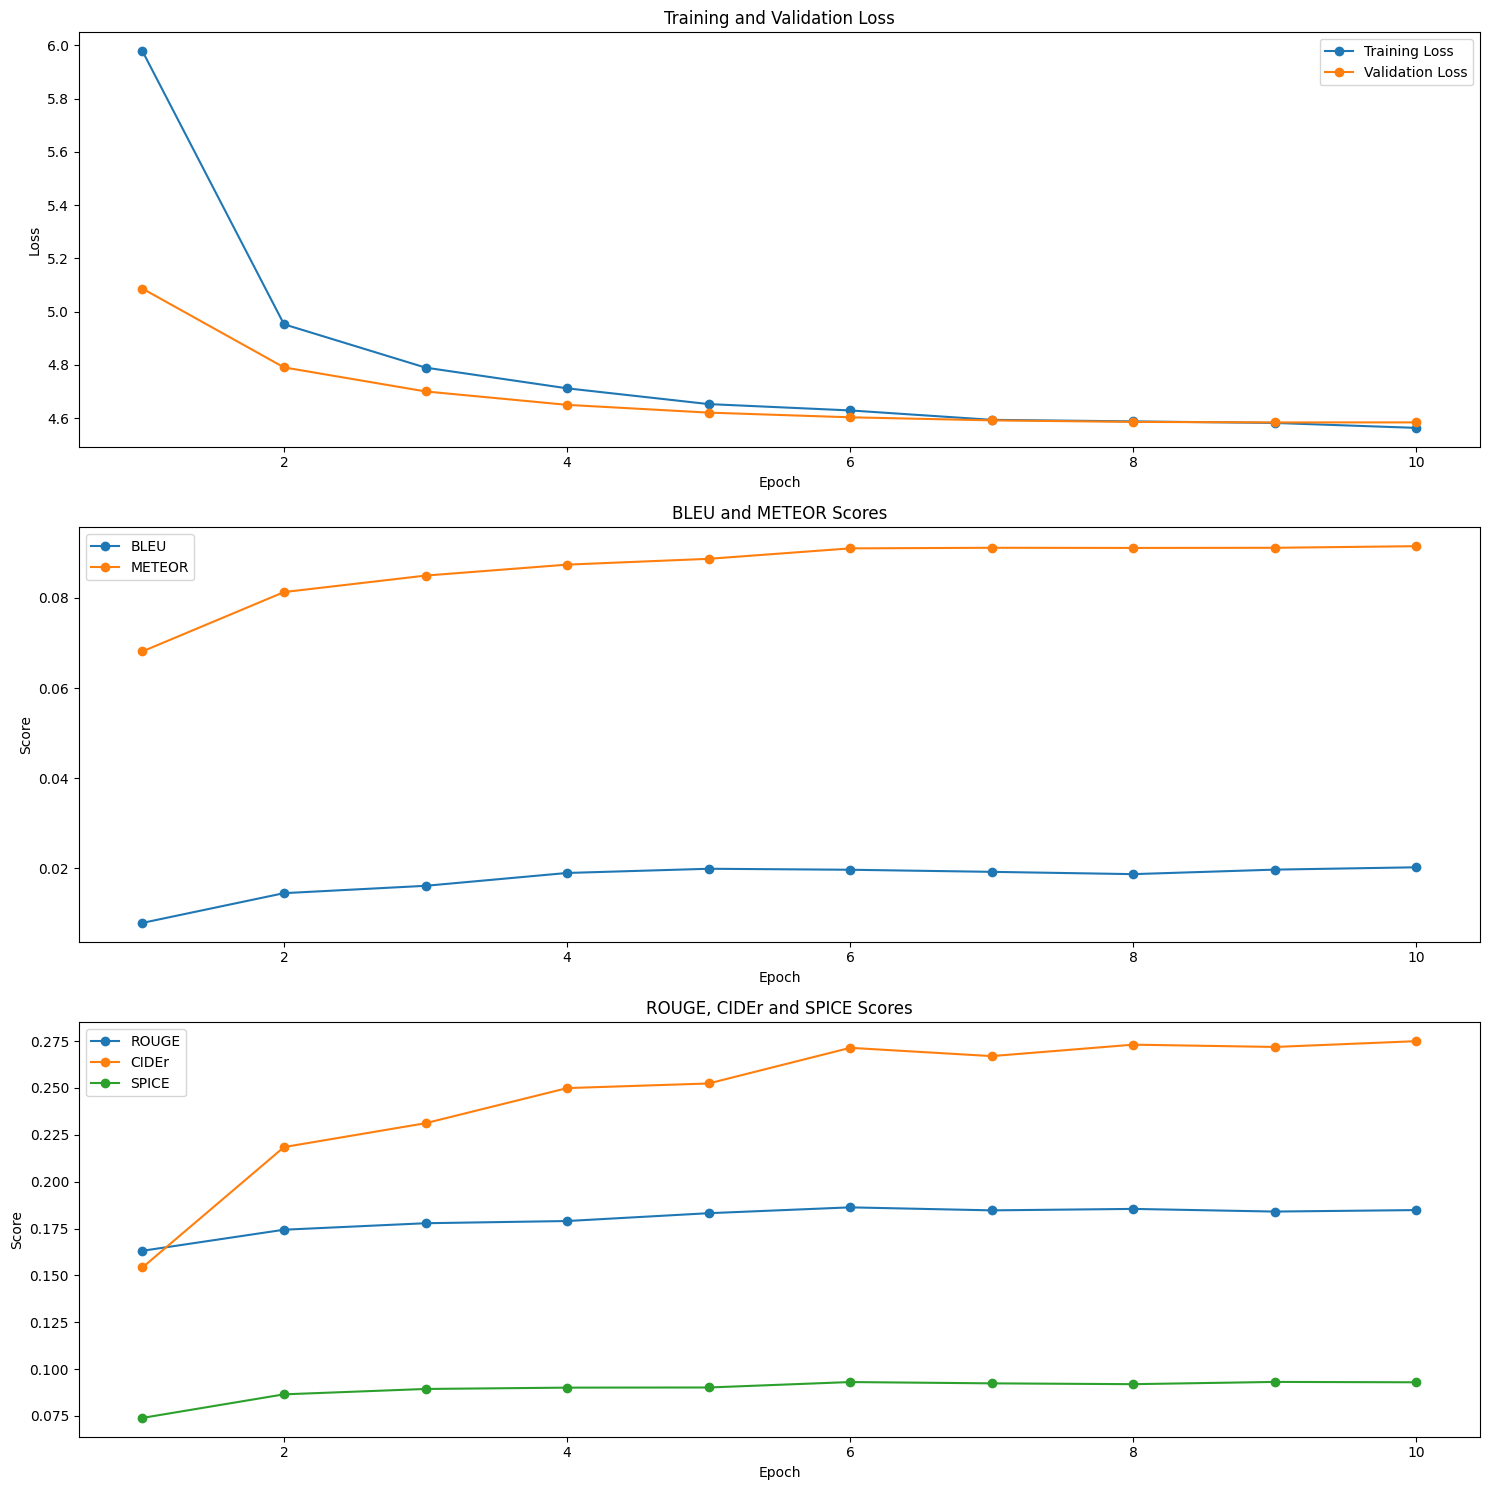

In [ ]:
### 시각화
epochs = range(1, num_epochs + 1)

plt.figure(figsize = (15, 15))

# 손실 곡선
plt.subplot(3, 1, 1)
plt.plot(epochs, train_losses, marker='o', label='Training Loss')
plt.plot(epochs, val_losses, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 평가 지표 1 (BLEU, METEOR)
plt.subplot(3, 1, 2)
plt.plot(epochs, bleu_scores, marker='o', label='BLEU')
plt.plot(epochs, meteor_scores, marker='o', label='METEOR')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('BLEU and METEOR Scores')
plt.legend()

# 평가 지표 2 (ROUGE, CIDEr, SPICE)
plt.subplot(3, 1, 3)
plt.plot(epochs, rouge_scores, marker='o', label='ROUGE')
plt.plot(epochs, cider_scores, marker='o', label='CIDEr')
plt.plot(epochs, spice_scores, marker='o', label='SPICE')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('ROUGE, CIDEr and SPICE Scores')
plt.legend()

plt.tight_layout()
plt.show()